<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/SWaT_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --quiet torch

In [1]:
# !pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2
# import pytorch_lightning as pl
# print(pl.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 6.6 MB/s 
     |████████████████████████████████| 776.8 MB 19 kB/s 
     |████████████████████████████████| 816 kB 48.1 MB/s 
     |████████████████████████████████| 140 kB 54.9 MB/s 
     |████████████████████████████████| 596 kB 32.0 MB/s 
     |████████████████████████████████| 829 kB 43.8 MB/s 
     |████████████████████████████████| 1.1 MB 41.6 MB/s 
     |████████████████████████████████| 144 kB 52.5 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 271 kB 8.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=dbad90ddbf9a2c32294f42dc5141b5a27d9b23fa8ee6d1a89fed881cba832b77
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: torch
    Found 

## import libary for preprocessing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from multiprocessing import cpu_count
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
%matplotlib inline
%config InlineBackend.figure_format= 'retina'

tqdm.pandas()

In [5]:
#set random seed
pl.seed_everything(44)

Global seed set to 44


44

## data preprocessing

In [6]:
!unzip -qq SWaT_Dataset_v0.zip

In [7]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [8]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_normal.columns.str.replace(' ','')

In [9]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [10]:
swat = pd.concat([swat_normal,swat_attack],axis = 0)

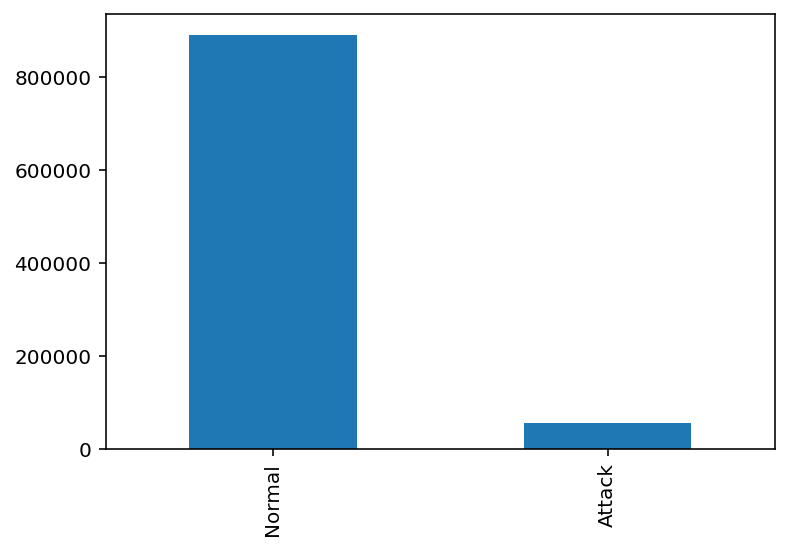

In [11]:
swat["Normal/Attack"].value_counts().plot(kind = "bar")


### Process normal data
use normal data for training & tuning time window (W) and threshold (T)


In [12]:
swat_normal.tail(5)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
496795,28/12/2015 9:59:55 AM,2.460366,523.0430,2,2,1,262.0161,8.396437,328.5055,2.442316,...,2,1,250.8171,1.778105,189.8552,0.000128,1,1,1,Normal
496796,28/12/2015 9:59:56 AM,2.448836,522.9645,2,2,1,262.0161,8.396437,328.5055,2.442316,...,2,1,250.8171,1.778105,189.5027,0.000128,1,1,1,Normal
496797,28/12/2015 9:59:57 AM,2.434744,522.8860,2,2,1,262.0161,8.396437,328.6337,2.444879,...,2,1,250.8171,1.778105,189.5027,0.000128,1,1,1,Normal
496798,28/12/2015 9:59:58 AM,2.428338,522.9252,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8171,1.649953,189.5027,0.000128,1,1,1,Normal
496799,28/12/2015 9:59:59 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal


In [13]:
swat_normal.describe()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
count,496800.000000,496800.00000,496800.000000,496800.000000,496800.0,496800.00000,496800.000000,496800.000000,496800.000000,496800.000000,...,496800.000000,496800.000000,496800.0,496800.000000,496800.000000,496800.000000,496800.000000,496800.0,496800.000000,496800.0
mean,1.844964,586.09884,1.718364,1.746860,1.0,263.73899,8.387852,348.230699,1.828534,1.744203,...,0.306141,1.993281,1.0,250.927892,1.183117,190.271470,0.014376,1.0,1.007915,1.0
std,1.135332,123.89144,0.458669,0.434811,0.0,4.83595,0.090236,49.422251,1.062482,0.444554,...,0.025356,0.081694,0.0,19.699763,0.216984,15.286211,0.148666,0.0,0.088612,0.0
min,0.000000,120.62370,0.000000,1.000000,1.0,244.32840,8.190080,300.845900,0.000000,0.000000,...,0.000000,1.000000,1.0,8.891951,0.000000,3.108177,0.000000,1.0,1.000000,1.0
25%,0.000000,508.24470,1.000000,1.000000,1.0,260.70240,8.349654,327.275100,0.008650,1.000000,...,0.306633,2.000000,1.0,249.951900,1.057252,188.974000,0.000000,1.0,1.000000,1.0
50%,2.491112,525.51590,2.000000,2.000000,1.0,265.28450,8.366636,330.940800,2.443085,2.000000,...,0.308362,2.000000,1.0,253.028100,1.121328,191.970000,0.000064,1.0,1.000000,1.0
75%,2.591679,675.85400,2.000000,2.000000,1.0,266.98280,8.407331,335.324300,2.451671,2.000000,...,0.310284,2.000000,1.0,255.030800,1.217441,193.860500,0.000128,1.0,1.000000,1.0
max,2.745092,1000.00000,2.000000,2.000000,1.0,272.52630,8.988273,567.469900,2.487938,2.000000,...,0.317010,2.000000,1.0,264.643700,3.668343,200.637600,1.746131,1.0,2.000000,1.0


In [14]:
swat_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496800 entries, 0 to 496799
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      496800 non-null  object 
 1   FIT101         496800 non-null  float64
 2   LIT101         496800 non-null  float64
 3   MV101          496800 non-null  int64  
 4   P101           496800 non-null  int64  
 5   P102           496800 non-null  int64  
 6   AIT201         496800 non-null  float64
 7   AIT202         496800 non-null  float64
 8   AIT203         496800 non-null  float64
 9   FIT201         496800 non-null  float64
 10  MV201          496800 non-null  int64  
 11  P201           496800 non-null  int64  
 12  P202           496800 non-null  int64  
 13  P203           496800 non-null  int64  
 14  P204           496800 non-null  int64  
 15  P205           496800 non-null  int64  
 16  P206           496800 non-null  int64  
 17  DPIT301        496800 non-nul

In [16]:
swat_normal.shape

(496800, 53)

In [15]:
swat_normal.isnull().any()

Timestamp        False
FIT101           False
LIT101           False
MV101            False
P101             False
P102             False
AIT201           False
AIT202           False
AIT203           False
FIT201           False
MV201            False
P201             False
P202             False
P203             False
P204             False
P205             False
P206             False
DPIT301          False
FIT301           False
LIT301           False
MV301            False
MV302            False
MV303            False
MV304            False
P301             False
P302             False
AIT401           False
AIT402           False
FIT401           False
LIT401           False
P401             False
P402             False
P403             False
P404             False
UV401            False
AIT501           False
AIT502           False
AIT503           False
AIT504           False
FIT501           False
FIT502           False
FIT503           False
FIT504           False
P501       

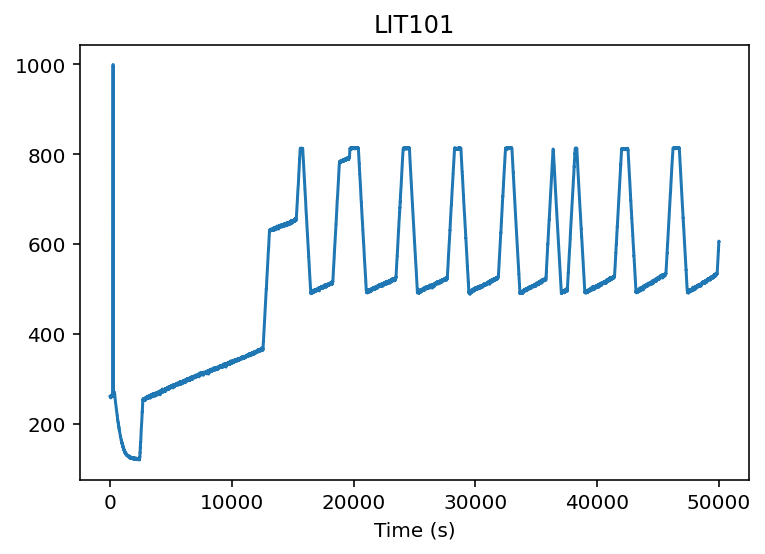

In [17]:
plt.plot(swat_normal.index[:50000],swat_normal["LIT101"][:50000], label='LIT101')
plt.xlabel("Time (s)")
plt.title("LIT101")
# plt.axvline(16000,c="r")
plt.show()

In [18]:
x = swat_normal.drop(columns="Normal/Attack")
y = swat_normal.drop(np.arange(16000))["Normal/Attack"]

In [19]:
y = pd.DataFrame(
    1, #normal 1, attack 0
    index = y.index,
    columns= ["label"]
)

In [20]:
# drop unsteady state operation
x.drop(np.arange(16000),inplace=True)

In [21]:
x.drop(columns="Timestamp",inplace=True)

In [22]:
#normalise data
scaler = StandardScaler()
scaler = scaler.fit(x)

In [23]:
x_scale = pd.DataFrame(
    scaler.transform(x),
    index = x.index,
    columns= x.columns
)

In [24]:
#convert to sequence
def sequences(input_data: pd.DataFrame, sequence_length):
    seqs = []
    data_size = len(input_data)
    
    for i in tqdm(range(0, data_size, sequence_length)):
        
        seq = input_data[i:i+sequence_length]
        
        
        seqs.append(seq)
        
    return seqs

In [25]:
# import time
sequence_length = 200
x_seq = sequences(x,sequence_length)

  0%|          | 0/2404 [00:00<?, ?it/s]

In [26]:
len(x_seq), x.shape

(2404, (480800, 51))

In [27]:
x_seq[0]

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
16000,0.0,720.0919,1,2,1,262.3366,8.380415,457.3955,2.476789,2,...,0.308362,2,1,253.5568,1.249479,192.7871,0.000128,1,1,1
16001,0.0,719.5815,1,2,1,262.3366,8.380415,457.3955,2.476789,2,...,0.308362,2,1,253.5568,1.249479,192.7871,0.000128,1,1,1
16002,0.0,719.3853,1,2,1,262.3366,8.380415,457.3443,2.476789,2,...,0.308362,2,1,253.5568,1.249479,192.7230,0.000128,1,1,1
16003,0.0,718.4040,1,2,1,262.3366,8.380415,457.1905,2.477045,2,...,0.310540,2,1,253.5568,1.249479,192.7230,0.000128,1,1,1
16004,0.0,717.4227,1,2,1,262.3366,8.380415,457.1392,2.477686,2,...,0.309900,2,1,253.5888,1.249479,192.7230,0.000128,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,0.0,623.7656,1,2,1,262.3366,8.376890,446.5009,2.470637,2,...,0.308298,2,1,253.6048,1.249479,192.8672,0.000128,1,1,1
16196,0.0,623.5301,1,2,1,262.3366,8.376890,446.5009,2.471663,2,...,0.308298,2,1,253.6048,1.249479,192.7230,0.000128,1,1,1
16197,0.0,623.2553,1,2,1,262.3366,8.376890,446.5009,2.471663,2,...,0.308298,2,1,253.6048,1.249479,192.7230,0.000128,1,1,1
16198,0.0,622.7057,1,2,1,262.3366,8.376890,446.5009,2.471663,2,...,0.308298,2,1,253.6048,1.249479,192.7230,0.000128,1,1,1


In [29]:
#split train/test use 80% train, 20% test (validation)
train_idx = int(len(x_seq)*0.8)
train_seq = x_seq[:train_idx]
test_seq = x_seq[train_idx:]


In [31]:
len(train_seq), len(test_seq)

(1923, 481)

### Attack data

In [ ]:
swat_attack.isnull().any()

Timestamp        False
FIT101           False
LIT101           False
MV101            False
P101             False
P102             False
AIT201           False
AIT202           False
AIT203           False
FIT201           False
MV201            False
P201             False
P202             False
P203             False
P204             False
P205             False
P206             False
DPIT301          False
FIT301           False
LIT301           False
MV301            False
MV302            False
MV303            False
MV304            False
P301             False
P302             False
AIT401           False
AIT402           False
FIT401           False
LIT401           False
P401             False
P402             False
P403             False
P404             False
UV401            False
AIT501           False
AIT502           False
AIT503           False
AIT504           False
FIT501           False
FIT502           False
FIT503           False
FIT504           False
P501       

In [ ]:
x_attack = swat_attack.drop(columns="Normal/Attack")
y_attack = swat_attack["Normal/Attack"]

In [ ]:
x_attack.drop(columns="Timestamp",inplace=True)

In [ ]:
x_scale_attack = pd.DataFrame(
    scaler.transform(x_attack),
    index = x_attack.index,
    columns= x_attack.columns
)

In [ ]:
label_encoder = LabelEncoder()
encoded = label_encoder.fit_transform(y_attack) 

In [ ]:
y_attack = pd.DataFrame(
    encoded, #normal 1, attack 0
    index = y_attack.index,
    columns= ["label"]
)

In [ ]:
test_seq = sequences(x_attack,y_attack,sequence_length)

  0%|          | 0/449619 [00:00<?, ?it/s]

In [ ]:
test_seq[0]

(       FIT101    LIT101  MV101  P101  P102    AIT201    AIT202    AIT203  \
 0    2.427057  522.8467      2     2     1  262.0161  8.396437  328.6337   
 1    2.446274  522.8860      2     2     1  262.0161  8.396437  328.6337   
 2    2.489191  522.8467      2     2     1  262.0161  8.394514  328.6337   
 3    2.534350  522.9645      2     2     1  262.0161  8.394514  328.6337   
 4    2.569260  523.4748      2     2     1  262.0161  8.394514  328.6337   
 ..        ...       ...    ...   ...   ...       ...       ...       ...   
 295  2.625308  529.2449      2     2     1  262.1764  8.394514  328.2492   
 296  2.621145  529.1272      2     2     1  262.1764  8.394514  328.2492   
 297  2.616981  528.7347      2     2     1  262.1764  8.394514  328.2492   
 298  2.602569  528.6169      2     2     1  262.1764  8.394514  328.0441   
 299  2.580790  528.2636      2     2     1  262.1764  8.394514  328.0441   
 
        FIT201  MV201  ...    FIT504  P501  P502    PIT501    PIT502    PI

## PyTorch Dataset

In [ ]:
class SWaTDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self,idx):
        sequences, label = self.sequences[idx]
        return dict(
        sequences = torch.Tensor(sequences.to_numpy()),
            label = torch.tensor(label).float()
        )

In [ ]:
class SWaTDataModule(pl.LightningDataModule):
    
    def __init__(self,train_seq,test_seq,val_seq,batch_size):
        super().__init__()
        self.train_seq = train_seq
        self.test_seq = test_seq
        self.val_seq = val_seq
        self.batch_size = batch_size
        
    def setup(self,stage = None):
        self.train_dataset = SWaTDataset(self.train_seq)
        self.test_dataset = SWaTDataset(self.test_seq)
        self.val_dataset = SWaTDataset(self.val_seq)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  

## build LSTM model

In [ ]:
n_epochs = 100
batch_size = 100


data_module = SWaTDataModule(train_seq,test_seq,val_seq,batch_size)

In [ ]:
class LSTMModel(nn.Module):
    
    def __init__(self,n_features,n_classes,n_hidden=128,n_layers=3):
        super().__init__()
        
        self.n_hidden = n_hidden
        
        self.criterion = nn.MSELoss()
        
        self.lstm = nn.LSTM(input_size = n_features, hidden_size = n_hidden,
                            num_layers = n_layers, batch_first = True, 
                            dropout = 0.75)
        
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self,x):
        self.lstm.flatten_parameters()
        
        _,(hidden, _) = self.lstm(x)
        
        out = hidden[-1]

        out = self.classifier(out)
        
        return out

In [ ]:
class SWaTPredictor(pl.LightningModule):
    
    def __init__(self, n_features:int, n_classes:int):
        super().__init__()
        self.model = LSTMModel(n_features,n_classes)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self,x,label=None):
        output = self.model(x)
        loss = 0
        
        if label is not None:
            loss = self.criterion(output, torch.max(label, 1)[1])
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions,torch.tensor(labels).int())
        
        self.log("train_loss", loss, prog_bar = True, logger=True)
        self.log("train_accuracy",step_accuracy, prog_bar = True, logger = True)
        return {"loss":loss, "accuracy": step_accuracy}
        
    def val_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions,torch.tensor(labels).int())
        
        self.log("val_loss", loss, prog_bar = True, logger=True)
        self.log("val_accuracy",step_accuracy, prog_bar = True, logger = True)
        return {"loss":loss, "accuracy": step_accuracy}

    def test_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions,torch.tensor(labels).int())
        
        self.log("test_loss", loss, prog_bar = True, logger=True)
        self.log("test_accuracy",step_accuracy, prog_bar = True, logger = True)
        return {"loss":loss, "accuracy": step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr= 0.0001)

In [ ]:
model = SWaTPredictor(
    n_features= len(x_scale.columns),
    n_classes= len(label_encoder.classes_))

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 793), started 1:07:11 ago. (Use '!kill 793' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k =1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("lightning_logs",name = "swat")

trainer = pl.Trainer(logger= logger, 
                     checkpoint_callback = checkpoint_callback,
                     max_epochs=n_epochs, 
                     gpus=1,
                     progress_bar_refresh_rate=30)

NameError: ignored

In [ ]:
trainer.fit(model, data_module)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | LSTMModel        | 357 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
357 K     Trainable params
0         Non-trainable params
357 K     Total params
1.428     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1501: val_loss reached 0.00006 (best 0.00006), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 3003: val_loss reached 0.00002 (best 0.00002), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 4505: val_loss reached 0.00001 (best 0.00001), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 6007: val_loss reached 0.00000 (best 0.00000), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 7509: val_loss reached 0.00000 (best 0.00000), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 9011: val_loss reached 0.00000 (best 0.00000), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 10513: val_loss reached 0.00000 (best 0.00000), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 12015: val_loss reached 0.00000 (best 0.00000), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 13517: val_loss reached 0.00000 (best 0.00000), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 15019: val_loss reached 0.00000 (best 0.00000), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


In [ ]:
trainer.test()

## Prediction

In [ ]:
train_model = SWaTPredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features = len([x_scale.columns]),
    n_classes= len(label_encoder.classes_))

train_model.freeze()